### A. Import

In [18]:
import pandas as pd
import numpy as np
import seaborn as sns
import openpyxl
import matplotlib.pyplot as plt
from tqdm import tqdm

from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
from sklearn.ensemble import ExtraTreesClassifier

from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier, RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

### B. Data Load

In [2]:
train = pd.read_csv('../data/train.csv').drop(columns=['ID'])
test = pd.read_csv('../data/test.csv').drop(columns=['ID'])

In [3]:
X = train.drop('임신 성공 여부', axis=1)
y = train['임신 성공 여부']

In [4]:
X.head(1)

,시술 시기 코드,시술 당시 나이,임신 시도 또는 마지막 임신 경과 연수,시술 유형,특정 시술 유형,배란 자극 여부,배란 유도 유형,단일 배아 이식 여부,착상 전 유전 검사 사용 여부,착상 전 유전 진단 사용 여부,...,신선 배아 사용 여부,기증 배아 사용 여부,대리모 여부,PGD 시술 여부,PGS 시술 여부,난자 채취 경과일,난자 해동 경과일,난자 혼합 경과일,배아 이식 경과일,배아 해동 경과일
0,TRZKPL,만18-34세,NaN,IVF,ICSI,1,기록되지 않은 시행,0.0,NaN,0.0,...,1.0,0.0,0.0,NaN,NaN,0.0,NaN,0.0,3.0,NaN


### C. Column Selection

In [5]:
# 범주형/수치형 컬럼 분류를 위해 label 파일 불러오기
label_df = pd.read_excel('../data/label.xlsx')

# 범주형 컬럼 필터링 
categorical_columns = label_df[label_df['범주형 여부'] == 1]['컬럼명'].tolist()
categorical_columns.append('특정 시술 유형')

# 수치형 컬럼 필터링
numerical_columns = [col for col in X.columns if col not in categorical_columns]


In [6]:
# 이진 컬럼 필터링
binary_columns = label_df[label_df['범주 정보'] == '0: False, 1: True']['컬럼명'].tolist()

# 범주형 컬럼에서 이진 컬럼 제거 
categorical_columns = [col for col in categorical_columns if col not in binary_columns]

In [7]:
print(f'수치형 컬럼: {len(numerical_columns)}')
print(f'범주형 컬럼: {len(categorical_columns)}')
print(f'이진 컬럼: {len(binary_columns)}')

수치형 컬럼: 20
범주형 컬럼: 26
이진 컬럼: 21


### D. Data Pre-processing

In [8]:
# 원본 데이터 복사
X_encoded = X.copy()

# 범주형 컬럼(Label Encoding 적용)
for col in categorical_columns:
    if col in X_encoded.columns:  # 존재하는 컬럼만 처리
        X_encoded[col] = X_encoded[col].fillna('missing').astype(str)  # 결측치 처리 + 문자열 변환
        le = LabelEncoder()  # 컬럼별 새로운 LabelEncoder 인스턴스 생성
        X_encoded[col] = le.fit_transform(X_encoded[col])

# 이진 컬럼 & 수치형 컬럼은 원본 유지
for col in binary_columns + numerical_columns:
    if col in X_encoded.columns:
        X_encoded[col] = X[col]

In [9]:
X_encoded = X_encoded.fillna(0)

In [22]:
test_encoded = test.copy()
for col in categorical_columns:
    if col in test_encoded.columns:  # 존재하는 컬럼만 처리
        test_encoded[col] = test_encoded[col].fillna('missing').astype(str)  # 결측치 처리 + 문자열 변환
        le = LabelEncoder()  # 컬럼별 새로운 LabelEncoder 인스턴스 생성
        test_encoded[col] = le.fit_transform(test_encoded[col])

# 이진 컬럼 & 수치형 컬럼은 원본 유지
for col in binary_columns + numerical_columns:
    if col in test_encoded.columns:
        test_encoded[col] = X[col]

In [23]:
test_encoded = test_encoded.fillna(0)

### E. Train

In [11]:
models = [
    XGBClassifier(random_state=42),
    LGBMClassifier(random_state=42),
    CatBoostClassifier(random_state=42, verbose=False),
    RandomForestClassifier(random_state=42),
    ExtraTreesClassifier(random_state=42),
    GradientBoostingClassifier(random_state=42),
    AdaBoostClassifier(random_state=42),
    DecisionTreeClassifier(random_state=42),
    KNeighborsClassifier(),
    LogisticRegression(random_state=42)
]

In [13]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=20, shuffle=True, random_state=42)
print(f"데이터셋 크기: {X.shape}")
print(f"\nK-fold 분할 정보:")
for fold, (train_idx, val_idx) in enumerate(kf.split(X)):
    print(f"Fold {fold+1:2d} - 학습 데이터: {len(train_idx):6d}개, 검증 데이터: {len(val_idx):6d}개")

데이터셋 크기: (256351, 67)

K-fold 분할 정보:
Fold  1 - 학습 데이터: 243533개, 검증 데이터:  12818개
Fold  2 - 학습 데이터: 243533개, 검증 데이터:  12818개
Fold  3 - 학습 데이터: 243533개, 검증 데이터:  12818개
Fold  4 - 학습 데이터: 243533개, 검증 데이터:  12818개
Fold  5 - 학습 데이터: 243533개, 검증 데이터:  12818개
Fold  6 - 학습 데이터: 243533개, 검증 데이터:  12818개
Fold  7 - 학습 데이터: 243533개, 검증 데이터:  12818개
Fold  8 - 학습 데이터: 243533개, 검증 데이터:  12818개
Fold  9 - 학습 데이터: 243533개, 검증 데이터:  12818개
Fold 10 - 학습 데이터: 243533개, 검증 데이터:  12818개
Fold 11 - 학습 데이터: 243533개, 검증 데이터:  12818개
Fold 12 - 학습 데이터: 243534개, 검증 데이터:  12817개
Fold 13 - 학습 데이터: 243534개, 검증 데이터:  12817개
Fold 14 - 학습 데이터: 243534개, 검증 데이터:  12817개
Fold 15 - 학습 데이터: 243534개, 검증 데이터:  12817개
Fold 16 - 학습 데이터: 243534개, 검증 데이터:  12817개
Fold 17 - 학습 데이터: 243534개, 검증 데이터:  12817개
Fold 18 - 학습 데이터: 243534개, 검증 데이터:  12817개
Fold 19 - 학습 데이터: 243534개, 검증 데이터:  12817개
Fold 20 - 학습 데이터: 243534개, 검증 데이터:  12817개


In [19]:
# 각 모델별 검증 정확도와 ROC-AUC를 저장할 딕셔너리
model_metrics = {}

# 각 모델에 대해 K-fold 교차 검증 수행
for model in models:
    fold_accuracies = []
    fold_roc_aucs = []
    
    # K-fold 교차 검증
    for fold, (train_idx, val_idx) in tqdm(enumerate(kf.split(X_encoded), 1), total=kf.get_n_splits(), desc=f"{model.__class__.__name__} is running..."):
        # 학습 데이터와 검증 데이터 분할
        X_train_fold = X_encoded.iloc[train_idx]
        y_train_fold = y.iloc[train_idx]
        X_val_fold = X_encoded.iloc[val_idx]
        y_val_fold = y.iloc[val_idx]
        
        # 모델 학습
        model.fit(X_train_fold, y_train_fold)
        
        # 검증 데이터에 대한 예측
        y_val_pred = model.predict(X_val_fold)
        y_val_pred_proba = model.predict_proba(X_val_fold)[:, 1]
        
        # 정확도와 ROC-AUC 계산
        accuracy = accuracy_score(y_val_fold, y_val_pred)
        roc_auc = roc_auc_score(y_val_fold, y_val_pred_proba)
        
        fold_accuracies.append(accuracy)
        fold_roc_aucs.append(roc_auc)
        
        print(f"Fold {fold+1:2d} - 정확도: {accuracy:.4f}, ROC-AUC: {roc_auc:.4f}")
    
    # 평균 정확도와 ROC-AUC 계산 및 저장
    mean_accuracy = np.mean(fold_accuracies)
    mean_roc_auc = np.mean(fold_roc_aucs)
    model_metrics[model.__class__.__name__] = {
        'accuracy': mean_accuracy,
        'roc_auc': mean_roc_auc
    }
    print(f"{model.__class__.__name__} - 평균 정확도: {mean_accuracy:.4f}, 평균 ROC-AUC: {mean_roc_auc:.4f}")


XGBClassifier is running...:   5%|▌         | 1/20 [00:00<00:13,  1.43it/s]

Fold  2 - 정확도: 0.7496, ROC-AUC: 0.7395


XGBClassifier is running...:  10%|█         | 2/20 [00:01<00:12,  1.48it/s]

Fold  3 - 정확도: 0.7494, ROC-AUC: 0.7356


XGBClassifier is running...:  15%|█▌        | 3/20 [00:02<00:11,  1.49it/s]

Fold  4 - 정확도: 0.7447, ROC-AUC: 0.7303


XGBClassifier is running...:  20%|██        | 4/20 [00:02<00:10,  1.50it/s]

Fold  5 - 정확도: 0.7383, ROC-AUC: 0.7384


XGBClassifier is running...:  25%|██▌       | 5/20 [00:03<00:09,  1.51it/s]

Fold  6 - 정확도: 0.7411, ROC-AUC: 0.7336


XGBClassifier is running...:  30%|███       | 6/20 [00:04<00:09,  1.51it/s]

Fold  7 - 정확도: 0.7359, ROC-AUC: 0.7326


XGBClassifier is running...:  35%|███▌      | 7/20 [00:04<00:08,  1.48it/s]

Fold  8 - 정확도: 0.7455, ROC-AUC: 0.7386


XGBClassifier is running...:  40%|████      | 8/20 [00:05<00:08,  1.46it/s]

Fold  9 - 정확도: 0.7472, ROC-AUC: 0.7409


XGBClassifier is running...:  45%|████▌     | 9/20 [00:06<00:07,  1.45it/s]

Fold 10 - 정확도: 0.7483, ROC-AUC: 0.7408


XGBClassifier is running...:  50%|█████     | 10/20 [00:06<00:06,  1.43it/s]

Fold 11 - 정확도: 0.7367, ROC-AUC: 0.7308


XGBClassifier is running...:  55%|█████▌    | 11/20 [00:07<00:06,  1.41it/s]

Fold 12 - 정확도: 0.7428, ROC-AUC: 0.7290


XGBClassifier is running...:  60%|██████    | 12/20 [00:08<00:05,  1.40it/s]

Fold 13 - 정확도: 0.7444, ROC-AUC: 0.7424


XGBClassifier is running...:  65%|██████▌   | 13/20 [00:08<00:04,  1.43it/s]

Fold 14 - 정확도: 0.7467, ROC-AUC: 0.7429


XGBClassifier is running...:  70%|███████   | 14/20 [00:09<00:04,  1.42it/s]

Fold 15 - 정확도: 0.7382, ROC-AUC: 0.7390


XGBClassifier is running...:  75%|███████▌  | 15/20 [00:10<00:03,  1.41it/s]

Fold 16 - 정확도: 0.7490, ROC-AUC: 0.7350


XGBClassifier is running...:  80%|████████  | 16/20 [00:11<00:02,  1.39it/s]

Fold 17 - 정확도: 0.7492, ROC-AUC: 0.7291


XGBClassifier is running...:  85%|████████▌ | 17/20 [00:11<00:02,  1.41it/s]

Fold 18 - 정확도: 0.7494, ROC-AUC: 0.7430


XGBClassifier is running...:  90%|█████████ | 18/20 [00:12<00:01,  1.40it/s]

Fold 19 - 정확도: 0.7433, ROC-AUC: 0.7400


XGBClassifier is running...:  95%|█████████▌| 19/20 [00:13<00:00,  1.39it/s]

Fold 20 - 정확도: 0.7428, ROC-AUC: 0.7377


XGBClassifier is running...: 100%|██████████| 20/20 [00:13<00:00,  1.43it/s]


Fold 21 - 정확도: 0.7484, ROC-AUC: 0.7414
XGBClassifier - 평균 정확도: 0.7445, 평균 ROC-AUC: 0.7370


LGBMClassifier is running...:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 62999, number of negative: 180534
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018832 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 713
[LightGBM] [Info] Number of data points in the train set: 243533, number of used features: 62
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.258688 -> initscore=-1.052800
[LightGBM] [Info] Start training from score -1.052800


LGBMClassifier is running...:   5%|▌         | 1/20 [00:01<00:21,  1.12s/it]

Fold  2 - 정확도: 0.7543, ROC-AUC: 0.7440
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 62956, number of negative: 180577
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015168 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 719
[LightGBM] [Info] Number of data points in the train set: 243533, number of used features: 62
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.258511 -> initscore=-1.053721
[LightGBM] [Info] Start training from score -1.053721


LGBMClassifier is running...:  10%|█         | 2/20 [00:02<00:19,  1.09s/it]

Fold  3 - 정확도: 0.7496, ROC-AUC: 0.7374
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 62964, number of negative: 180569
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016292 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 716
[LightGBM] [Info] Number of data points in the train set: 243533, number of used features: 62
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.258544 -> initscore=-1.053550
[LightGBM] [Info] Start training from score -1.053550


LGBMClassifier is running...:  15%|█▌        | 3/20 [00:03<00:18,  1.10s/it]

Fold  4 - 정확도: 0.7462, ROC-AUC: 0.7318
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 62867, number of negative: 180666
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017007 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 710
[LightGBM] [Info] Number of data points in the train set: 243533, number of used features: 62
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.258146 -> initscore=-1.055629
[LightGBM] [Info] Start training from score -1.055629


LGBMClassifier is running...:  20%|██        | 4/20 [00:04<00:17,  1.08s/it]

Fold  5 - 정확도: 0.7436, ROC-AUC: 0.7419
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 62870, number of negative: 180663
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018989 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 716
[LightGBM] [Info] Number of data points in the train set: 243533, number of used features: 62
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.258158 -> initscore=-1.055564
[LightGBM] [Info] Start training from score -1.055564


LGBMClassifier is running...:  25%|██▌       | 5/20 [00:05<00:16,  1.07s/it]

Fold  6 - 정확도: 0.7404, ROC-AUC: 0.7350
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 62823, number of negative: 180710
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021534 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 715
[LightGBM] [Info] Number of data points in the train set: 243533, number of used features: 62
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.257965 -> initscore=-1.056572
[LightGBM] [Info] Start training from score -1.056572


LGBMClassifier is running...:  30%|███       | 6/20 [00:06<00:15,  1.07s/it]

Fold  7 - 정확도: 0.7368, ROC-AUC: 0.7355
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 62918, number of negative: 180615
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015906 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 724
[LightGBM] [Info] Number of data points in the train set: 243533, number of used features: 62
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.258355 -> initscore=-1.054535
[LightGBM] [Info] Start training from score -1.054535


LGBMClassifier is running...:  35%|███▌      | 7/20 [00:07<00:13,  1.07s/it]

Fold  8 - 정확도: 0.7453, ROC-AUC: 0.7417
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 62949, number of negative: 180584
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018429 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 714
[LightGBM] [Info] Number of data points in the train set: 243533, number of used features: 62
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.258482 -> initscore=-1.053871
[LightGBM] [Info] Start training from score -1.053871


LGBMClassifier is running...:  40%|████      | 8/20 [00:08<00:13,  1.09s/it]

Fold  9 - 정확도: 0.7496, ROC-AUC: 0.7428
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 62938, number of negative: 180595
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019580 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 714
[LightGBM] [Info] Number of data points in the train set: 243533, number of used features: 62
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.258437 -> initscore=-1.054107
[LightGBM] [Info] Start training from score -1.054107


LGBMClassifier is running...:  45%|████▌     | 9/20 [00:09<00:12,  1.10s/it]

Fold 10 - 정확도: 0.7491, ROC-AUC: 0.7429
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 62828, number of negative: 180705
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014100 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 712
[LightGBM] [Info] Number of data points in the train set: 243533, number of used features: 62
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.257986 -> initscore=-1.056465
[LightGBM] [Info] Start training from score -1.056465


LGBMClassifier is running...:  50%|█████     | 10/20 [00:10<00:11,  1.11s/it]

Fold 11 - 정확도: 0.7360, ROC-AUC: 0.7313
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 62940, number of negative: 180593
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015024 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 716
[LightGBM] [Info] Number of data points in the train set: 243533, number of used features: 62
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.258445 -> initscore=-1.054064
[LightGBM] [Info] Start training from score -1.054064


LGBMClassifier is running...:  55%|█████▌    | 11/20 [00:12<00:09,  1.11s/it]

Fold 12 - 정확도: 0.7471, ROC-AUC: 0.7316
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 62883, number of negative: 180651
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018831 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 714
[LightGBM] [Info] Number of data points in the train set: 243534, number of used features: 62
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.258210 -> initscore=-1.055291
[LightGBM] [Info] Start training from score -1.055291


LGBMClassifier is running...:  60%|██████    | 12/20 [00:13<00:08,  1.10s/it]

Fold 13 - 정확도: 0.7436, ROC-AUC: 0.7439
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 62929, number of negative: 180605
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016033 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 714
[LightGBM] [Info] Number of data points in the train set: 243534, number of used features: 62
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.258399 -> initscore=-1.054305
[LightGBM] [Info] Start training from score -1.054305


LGBMClassifier is running...:  65%|██████▌   | 13/20 [00:14<00:07,  1.06s/it]

Fold 14 - 정확도: 0.7483, ROC-AUC: 0.7457
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 62831, number of negative: 180703
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018560 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 716
[LightGBM] [Info] Number of data points in the train set: 243534, number of used features: 62
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.257997 -> initscore=-1.056406
[LightGBM] [Info] Start training from score -1.056406


LGBMClassifier is running...:  70%|███████   | 14/20 [00:14<00:06,  1.00s/it]

Fold 15 - 정확도: 0.7396, ROC-AUC: 0.7424
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 62988, number of negative: 180546
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019374 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 720
[LightGBM] [Info] Number of data points in the train set: 243534, number of used features: 62
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.258642 -> initscore=-1.053041
[LightGBM] [Info] Start training from score -1.053041


LGBMClassifier is running...:  75%|███████▌  | 15/20 [00:15<00:04,  1.04it/s]

Fold 16 - 정확도: 0.7515, ROC-AUC: 0.7390
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 62987, number of negative: 180547
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017938 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 717
[LightGBM] [Info] Number of data points in the train set: 243534, number of used features: 62
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.258637 -> initscore=-1.053063
[LightGBM] [Info] Start training from score -1.053063


LGBMClassifier is running...:  80%|████████  | 16/20 [00:16<00:03,  1.08it/s]

Fold 17 - 정확도: 0.7488, ROC-AUC: 0.7321
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 62969, number of negative: 180565
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018414 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 718
[LightGBM] [Info] Number of data points in the train set: 243534, number of used features: 62
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.258563 -> initscore=-1.053448
[LightGBM] [Info] Start training from score -1.053448


LGBMClassifier is running...:  85%|████████▌ | 17/20 [00:17<00:02,  1.09it/s]

Fold 18 - 정확도: 0.7498, ROC-AUC: 0.7433
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 62900, number of negative: 180634
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.020088 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 717
[LightGBM] [Info] Number of data points in the train set: 243534, number of used features: 62
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.258280 -> initscore=-1.054927
[LightGBM] [Info] Start training from score -1.054927


LGBMClassifier is running...:  90%|█████████ | 18/20 [00:18<00:01,  1.04it/s]

Fold 19 - 정확도: 0.7458, ROC-AUC: 0.7420
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 62864, number of negative: 180670
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019029 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 717
[LightGBM] [Info] Number of data points in the train set: 243534, number of used features: 62
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.258132 -> initscore=-1.055698
[LightGBM] [Info] Start training from score -1.055698


LGBMClassifier is running...:  95%|█████████▌| 19/20 [00:19<00:00,  1.02it/s]

Fold 20 - 정확도: 0.7438, ROC-AUC: 0.7401
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 62929, number of negative: 180605
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018486 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 712
[LightGBM] [Info] Number of data points in the train set: 243534, number of used features: 62
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.258399 -> initscore=-1.054305
[LightGBM] [Info] Start training from score -1.054305


LGBMClassifier is running...: 100%|██████████| 20/20 [00:20<00:00,  1.03s/it]


Fold 21 - 정확도: 0.7459, ROC-AUC: 0.7437
LGBMClassifier - 평균 정확도: 0.7457, 평균 ROC-AUC: 0.7394


CatBoostClassifier is running...:   5%|▌         | 1/20 [00:15<04:50, 15.27s/it]

Fold  2 - 정확도: 0.7511, ROC-AUC: 0.7407


CatBoostClassifier is running...:  10%|█         | 2/20 [00:30<04:33, 15.19s/it]

Fold  3 - 정확도: 0.7497, ROC-AUC: 0.7367


CatBoostClassifier is running...:  15%|█▌        | 3/20 [00:44<04:09, 14.71s/it]

Fold  4 - 정확도: 0.7443, ROC-AUC: 0.7292


CatBoostClassifier is running...:  20%|██        | 4/20 [00:58<03:49, 14.34s/it]

Fold  5 - 정확도: 0.7399, ROC-AUC: 0.7388


CatBoostClassifier is running...:  25%|██▌       | 5/20 [01:12<03:32, 14.16s/it]

Fold  6 - 정확도: 0.7402, ROC-AUC: 0.7355


CatBoostClassifier is running...:  30%|███       | 6/20 [01:25<03:16, 14.04s/it]

Fold  7 - 정확도: 0.7365, ROC-AUC: 0.7341


CatBoostClassifier is running...:  35%|███▌      | 7/20 [01:39<03:00, 13.90s/it]

Fold  8 - 정확도: 0.7442, ROC-AUC: 0.7386


CatBoostClassifier is running...:  40%|████      | 8/20 [01:53<02:47, 13.95s/it]

Fold  9 - 정확도: 0.7476, ROC-AUC: 0.7406


CatBoostClassifier is running...:  45%|████▌     | 9/20 [02:07<02:32, 13.84s/it]

Fold 10 - 정확도: 0.7501, ROC-AUC: 0.7398


CatBoostClassifier is running...:  50%|█████     | 10/20 [02:21<02:18, 13.88s/it]

Fold 11 - 정확도: 0.7335, ROC-AUC: 0.7305


CatBoostClassifier is running...:  55%|█████▌    | 11/20 [02:35<02:04, 13.88s/it]

Fold 12 - 정확도: 0.7472, ROC-AUC: 0.7298


CatBoostClassifier is running...:  60%|██████    | 12/20 [02:48<01:50, 13.80s/it]

Fold 13 - 정확도: 0.7454, ROC-AUC: 0.7439


CatBoostClassifier is running...:  65%|██████▌   | 13/20 [03:02<01:36, 13.76s/it]

Fold 14 - 정확도: 0.7485, ROC-AUC: 0.7424


CatBoostClassifier is running...:  70%|███████   | 14/20 [03:16<01:23, 13.84s/it]

Fold 15 - 정확도: 0.7378, ROC-AUC: 0.7401


CatBoostClassifier is running...:  75%|███████▌  | 15/20 [03:30<01:09, 13.97s/it]

Fold 16 - 정확도: 0.7504, ROC-AUC: 0.7377


CatBoostClassifier is running...:  80%|████████  | 16/20 [03:44<00:55, 13.91s/it]

Fold 17 - 정확도: 0.7488, ROC-AUC: 0.7300


CatBoostClassifier is running...:  85%|████████▌ | 17/20 [03:58<00:41, 13.91s/it]

Fold 18 - 정확도: 0.7488, ROC-AUC: 0.7420


CatBoostClassifier is running...:  90%|█████████ | 18/20 [04:12<00:27, 13.84s/it]

Fold 19 - 정확도: 0.7465, ROC-AUC: 0.7403


CatBoostClassifier is running...:  95%|█████████▌| 19/20 [04:25<00:13, 13.76s/it]

Fold 20 - 정확도: 0.7428, ROC-AUC: 0.7397


CatBoostClassifier is running...: 100%|██████████| 20/20 [04:38<00:00, 13.93s/it]


Fold 21 - 정확도: 0.7474, ROC-AUC: 0.7439
CatBoostClassifier - 평균 정확도: 0.7450, 평균 ROC-AUC: 0.7377


RandomForestClassifier is running...:   5%|▌         | 1/20 [00:41<13:03, 41.23s/it]

Fold  2 - 정확도: 0.7312, ROC-AUC: 0.7077


RandomForestClassifier is running...:  10%|█         | 2/20 [01:21<12:14, 40.81s/it]

Fold  3 - 정확도: 0.7277, ROC-AUC: 0.6986


RandomForestClassifier is running...:  15%|█▌        | 3/20 [02:00<11:18, 39.92s/it]

Fold  4 - 정확도: 0.7258, ROC-AUC: 0.6979


RandomForestClassifier is running...:  20%|██        | 4/20 [02:39<10:30, 39.43s/it]

Fold  5 - 정확도: 0.7229, ROC-AUC: 0.7104


RandomForestClassifier is running...:  25%|██▌       | 5/20 [03:18<09:48, 39.23s/it]

Fold  6 - 정확도: 0.7190, ROC-AUC: 0.6922


RandomForestClassifier is running...:  30%|███       | 6/20 [04:00<09:25, 40.42s/it]

Fold  7 - 정확도: 0.7195, ROC-AUC: 0.6935


RandomForestClassifier is running...:  35%|███▌      | 7/20 [04:40<08:39, 40.00s/it]

Fold  8 - 정확도: 0.7292, ROC-AUC: 0.7042


RandomForestClassifier is running...:  40%|████      | 8/20 [05:21<08:07, 40.63s/it]

Fold  9 - 정확도: 0.7234, ROC-AUC: 0.7060


RandomForestClassifier is running...:  45%|████▌     | 9/20 [06:02<07:26, 40.60s/it]

Fold 10 - 정확도: 0.7301, ROC-AUC: 0.7021


RandomForestClassifier is running...:  50%|█████     | 10/20 [06:42<06:44, 40.45s/it]

Fold 11 - 정확도: 0.7204, ROC-AUC: 0.6968


RandomForestClassifier is running...:  55%|█████▌    | 11/20 [07:24<06:06, 40.78s/it]

Fold 12 - 정확도: 0.7275, ROC-AUC: 0.6981


RandomForestClassifier is running...:  60%|██████    | 12/20 [08:03<05:21, 40.24s/it]

Fold 13 - 정확도: 0.7287, ROC-AUC: 0.7113


RandomForestClassifier is running...:  65%|██████▌   | 13/20 [08:42<04:40, 40.02s/it]

Fold 14 - 정확도: 0.7280, ROC-AUC: 0.7062


RandomForestClassifier is running...:  70%|███████   | 14/20 [09:21<03:57, 39.53s/it]

Fold 15 - 정확도: 0.7236, ROC-AUC: 0.7020


RandomForestClassifier is running...:  75%|███████▌  | 15/20 [10:00<03:17, 39.55s/it]

Fold 16 - 정확도: 0.7332, ROC-AUC: 0.7019


RandomForestClassifier is running...:  80%|████████  | 16/20 [10:39<02:36, 39.24s/it]

Fold 17 - 정확도: 0.7275, ROC-AUC: 0.6955


RandomForestClassifier is running...:  85%|████████▌ | 17/20 [11:18<01:57, 39.22s/it]

Fold 18 - 정확도: 0.7301, ROC-AUC: 0.7032


RandomForestClassifier is running...:  90%|█████████ | 18/20 [11:57<01:18, 39.20s/it]

Fold 19 - 정확도: 0.7258, ROC-AUC: 0.7074


RandomForestClassifier is running...:  95%|█████████▌| 19/20 [12:36<00:39, 39.07s/it]

Fold 20 - 정확도: 0.7191, ROC-AUC: 0.7050


RandomForestClassifier is running...: 100%|██████████| 20/20 [13:15<00:00, 39.78s/it]


Fold 21 - 정확도: 0.7287, ROC-AUC: 0.7024
RandomForestClassifier - 평균 정확도: 0.7261, 평균 ROC-AUC: 0.7021


ExtraTreesClassifier is running...:   5%|▌         | 1/20 [00:48<15:26, 48.75s/it]

Fold  2 - 정확도: 0.7210, ROC-AUC: 0.6962


ExtraTreesClassifier is running...:  10%|█         | 2/20 [01:40<15:13, 50.75s/it]

Fold  3 - 정확도: 0.7213, ROC-AUC: 0.6900


ExtraTreesClassifier is running...:  15%|█▌        | 3/20 [02:33<14:38, 51.68s/it]

Fold  4 - 정확도: 0.7157, ROC-AUC: 0.6847


ExtraTreesClassifier is running...:  20%|██        | 4/20 [03:25<13:47, 51.75s/it]

Fold  5 - 정확도: 0.7121, ROC-AUC: 0.6959


ExtraTreesClassifier is running...:  25%|██▌       | 5/20 [04:17<12:56, 51.76s/it]

Fold  6 - 정확도: 0.7103, ROC-AUC: 0.6819


ExtraTreesClassifier is running...:  30%|███       | 6/20 [05:10<12:10, 52.17s/it]

Fold  7 - 정확도: 0.7057, ROC-AUC: 0.6807


ExtraTreesClassifier is running...:  35%|███▌      | 7/20 [06:03<11:24, 52.64s/it]

Fold  8 - 정확도: 0.7181, ROC-AUC: 0.6910


ExtraTreesClassifier is running...:  40%|████      | 8/20 [06:56<10:30, 52.58s/it]

Fold  9 - 정확도: 0.7150, ROC-AUC: 0.6949


ExtraTreesClassifier is running...:  45%|████▌     | 9/20 [07:44<09:21, 51.08s/it]

Fold 10 - 정확도: 0.7176, ROC-AUC: 0.6902


ExtraTreesClassifier is running...:  50%|█████     | 10/20 [08:35<08:32, 51.24s/it]

Fold 11 - 정확도: 0.7159, ROC-AUC: 0.6823


ExtraTreesClassifier is running...:  55%|█████▌    | 11/20 [09:27<07:43, 51.45s/it]

Fold 12 - 정확도: 0.7156, ROC-AUC: 0.6843


ExtraTreesClassifier is running...:  60%|██████    | 12/20 [10:19<06:53, 51.65s/it]

Fold 13 - 정확도: 0.7174, ROC-AUC: 0.6944


ExtraTreesClassifier is running...:  65%|██████▌   | 13/20 [11:09<05:57, 51.01s/it]

Fold 14 - 정확도: 0.7173, ROC-AUC: 0.6915


ExtraTreesClassifier is running...:  70%|███████   | 14/20 [11:58<05:02, 50.34s/it]

Fold 15 - 정확도: 0.7104, ROC-AUC: 0.6894


ExtraTreesClassifier is running...:  75%|███████▌  | 15/20 [12:47<04:10, 50.05s/it]

Fold 16 - 정확도: 0.7206, ROC-AUC: 0.6868


ExtraTreesClassifier is running...:  80%|████████  | 16/20 [13:38<03:21, 50.38s/it]

Fold 17 - 정확도: 0.7166, ROC-AUC: 0.6837


ExtraTreesClassifier is running...:  85%|████████▌ | 17/20 [14:26<02:29, 49.73s/it]

Fold 18 - 정확도: 0.7166, ROC-AUC: 0.6879


ExtraTreesClassifier is running...:  90%|█████████ | 18/20 [15:16<01:39, 49.59s/it]

Fold 19 - 정확도: 0.7133, ROC-AUC: 0.6955


ExtraTreesClassifier is running...:  95%|█████████▌| 19/20 [16:04<00:49, 49.09s/it]

Fold 20 - 정확도: 0.7140, ROC-AUC: 0.6970


ExtraTreesClassifier is running...: 100%|██████████| 20/20 [16:54<00:00, 50.73s/it]


Fold 21 - 정확도: 0.7169, ROC-AUC: 0.6897
ExtraTreesClassifier - 평균 정확도: 0.7156, 평균 ROC-AUC: 0.6894


GradientBoostingClassifier is running...:   5%|▌         | 1/20 [00:44<13:57, 44.07s/it]

Fold  2 - 정확도: 0.7551, ROC-AUC: 0.7421


GradientBoostingClassifier is running...:  10%|█         | 2/20 [01:27<13:09, 43.85s/it]

Fold  3 - 정확도: 0.7504, ROC-AUC: 0.7374


GradientBoostingClassifier is running...:  15%|█▌        | 3/20 [02:11<12:22, 43.67s/it]

Fold  4 - 정확도: 0.7450, ROC-AUC: 0.7299


GradientBoostingClassifier is running...:  20%|██        | 4/20 [02:55<11:41, 43.87s/it]

Fold  5 - 정확도: 0.7436, ROC-AUC: 0.7394


GradientBoostingClassifier is running...:  25%|██▌       | 5/20 [03:39<10:57, 43.81s/it]

Fold  6 - 정확도: 0.7424, ROC-AUC: 0.7331


GradientBoostingClassifier is running...:  30%|███       | 6/20 [04:22<10:12, 43.78s/it]

Fold  7 - 정확도: 0.7355, ROC-AUC: 0.7342


GradientBoostingClassifier is running...:  35%|███▌      | 7/20 [05:06<09:27, 43.68s/it]

Fold  8 - 정확도: 0.7455, ROC-AUC: 0.7406


GradientBoostingClassifier is running...:  40%|████      | 8/20 [05:50<08:44, 43.70s/it]

Fold  9 - 정확도: 0.7492, ROC-AUC: 0.7414


GradientBoostingClassifier is running...:  45%|████▌     | 9/20 [06:33<08:00, 43.70s/it]

Fold 10 - 정확도: 0.7489, ROC-AUC: 0.7421


GradientBoostingClassifier is running...:  50%|█████     | 10/20 [07:17<07:16, 43.65s/it]

Fold 11 - 정확도: 0.7368, ROC-AUC: 0.7304


GradientBoostingClassifier is running...:  55%|█████▌    | 11/20 [08:00<06:32, 43.59s/it]

Fold 12 - 정확도: 0.7475, ROC-AUC: 0.7295


GradientBoostingClassifier is running...:  60%|██████    | 12/20 [08:44<05:48, 43.56s/it]

Fold 13 - 정확도: 0.7447, ROC-AUC: 0.7432


GradientBoostingClassifier is running...:  65%|██████▌   | 13/20 [09:27<05:05, 43.58s/it]

Fold 14 - 정확도: 0.7477, ROC-AUC: 0.7440


GradientBoostingClassifier is running...:  70%|███████   | 14/20 [10:11<04:21, 43.64s/it]

Fold 15 - 정확도: 0.7396, ROC-AUC: 0.7401


GradientBoostingClassifier is running...:  75%|███████▌  | 15/20 [10:55<03:38, 43.62s/it]

Fold 16 - 정확도: 0.7503, ROC-AUC: 0.7377


GradientBoostingClassifier is running...:  80%|████████  | 16/20 [11:39<02:55, 43.76s/it]

Fold 17 - 정확도: 0.7494, ROC-AUC: 0.7307


GradientBoostingClassifier is running...:  85%|████████▌ | 17/20 [12:22<02:10, 43.66s/it]

Fold 18 - 정확도: 0.7500, ROC-AUC: 0.7405


GradientBoostingClassifier is running...:  90%|█████████ | 18/20 [13:06<01:27, 43.70s/it]

Fold 19 - 정확도: 0.7468, ROC-AUC: 0.7404


GradientBoostingClassifier is running...:  95%|█████████▌| 19/20 [13:50<00:43, 43.71s/it]

Fold 20 - 정확도: 0.7442, ROC-AUC: 0.7397


GradientBoostingClassifier is running...: 100%|██████████| 20/20 [14:34<00:00, 43.70s/it]


Fold 21 - 정확도: 0.7470, ROC-AUC: 0.7418
GradientBoostingClassifier - 평균 정확도: 0.7460, 평균 ROC-AUC: 0.7379


AdaBoostClassifier is running...:   5%|▌         | 1/20 [00:10<03:18, 10.47s/it]

Fold  2 - 정확도: 0.7515, ROC-AUC: 0.7254


AdaBoostClassifier is running...:  10%|█         | 2/20 [00:21<03:10, 10.59s/it]

Fold  3 - 정확도: 0.7465, ROC-AUC: 0.7230


AdaBoostClassifier is running...:  15%|█▌        | 3/20 [00:31<02:58, 10.50s/it]

Fold  4 - 정확도: 0.7456, ROC-AUC: 0.7112


AdaBoostClassifier is running...:  20%|██        | 4/20 [00:41<02:46, 10.43s/it]

Fold  5 - 정확도: 0.7386, ROC-AUC: 0.7214


AdaBoostClassifier is running...:  25%|██▌       | 5/20 [00:52<02:35, 10.39s/it]

Fold  6 - 정확도: 0.7397, ROC-AUC: 0.7203


AdaBoostClassifier is running...:  30%|███       | 6/20 [01:02<02:25, 10.36s/it]

Fold  7 - 정확도: 0.7349, ROC-AUC: 0.7193


AdaBoostClassifier is running...:  35%|███▌      | 7/20 [01:12<02:14, 10.33s/it]

Fold  8 - 정확도: 0.7428, ROC-AUC: 0.7238


AdaBoostClassifier is running...:  40%|████      | 8/20 [01:23<02:04, 10.35s/it]

Fold  9 - 정확도: 0.7487, ROC-AUC: 0.7252


AdaBoostClassifier is running...:  45%|████▌     | 9/20 [01:33<01:53, 10.34s/it]

Fold 10 - 정확도: 0.7453, ROC-AUC: 0.7251


AdaBoostClassifier is running...:  50%|█████     | 10/20 [01:43<01:43, 10.38s/it]

Fold 11 - 정확도: 0.7337, ROC-AUC: 0.7157


AdaBoostClassifier is running...:  55%|█████▌    | 11/20 [01:54<01:33, 10.36s/it]

Fold 12 - 정확도: 0.7452, ROC-AUC: 0.7139


AdaBoostClassifier is running...:  60%|██████    | 12/20 [02:04<01:23, 10.38s/it]

Fold 13 - 정확도: 0.7437, ROC-AUC: 0.7270


AdaBoostClassifier is running...:  65%|██████▌   | 13/20 [02:14<01:12, 10.36s/it]

Fold 14 - 정확도: 0.7435, ROC-AUC: 0.7312


AdaBoostClassifier is running...:  70%|███████   | 14/20 [02:25<01:02, 10.35s/it]

Fold 15 - 정확도: 0.7371, ROC-AUC: 0.7251


AdaBoostClassifier is running...:  75%|███████▌  | 15/20 [02:35<00:52, 10.40s/it]

Fold 16 - 정확도: 0.7470, ROC-AUC: 0.7227


AdaBoostClassifier is running...:  80%|████████  | 16/20 [02:46<00:41, 10.38s/it]

Fold 17 - 정확도: 0.7450, ROC-AUC: 0.7124


AdaBoostClassifier is running...:  85%|████████▌ | 17/20 [02:56<00:31, 10.44s/it]

Fold 18 - 정확도: 0.7464, ROC-AUC: 0.7237


AdaBoostClassifier is running...:  90%|█████████ | 18/20 [03:07<00:20, 10.44s/it]

Fold 19 - 정확도: 0.7432, ROC-AUC: 0.7247


AdaBoostClassifier is running...:  95%|█████████▌| 19/20 [03:17<00:10, 10.44s/it]

Fold 20 - 정확도: 0.7395, ROC-AUC: 0.7249


AdaBoostClassifier is running...: 100%|██████████| 20/20 [03:28<00:00, 10.40s/it]


Fold 21 - 정확도: 0.7443, ROC-AUC: 0.7244
AdaBoostClassifier - 평균 정확도: 0.7431, 평균 ROC-AUC: 0.7220


DecisionTreeClassifier is running...:   5%|▌         | 1/20 [00:03<01:00,  3.18s/it]

Fold  2 - 정확도: 0.6660, ROC-AUC: 0.5727


DecisionTreeClassifier is running...:  10%|█         | 2/20 [00:06<00:57,  3.19s/it]

Fold  3 - 정확도: 0.6673, ROC-AUC: 0.5734


DecisionTreeClassifier is running...:  15%|█▌        | 3/20 [00:09<00:53,  3.14s/it]

Fold  4 - 정확도: 0.6627, ROC-AUC: 0.5681


DecisionTreeClassifier is running...:  20%|██        | 4/20 [00:12<00:50,  3.15s/it]

Fold  5 - 정확도: 0.6595, ROC-AUC: 0.5691


DecisionTreeClassifier is running...:  25%|██▌       | 5/20 [00:15<00:47,  3.15s/it]

Fold  6 - 정확도: 0.6524, ROC-AUC: 0.5592


DecisionTreeClassifier is running...:  30%|███       | 6/20 [00:18<00:43,  3.13s/it]

Fold  7 - 정확도: 0.6534, ROC-AUC: 0.5640


DecisionTreeClassifier is running...:  35%|███▌      | 7/20 [00:21<00:40,  3.11s/it]

Fold  8 - 정확도: 0.6657, ROC-AUC: 0.5727


DecisionTreeClassifier is running...:  40%|████      | 8/20 [00:25<00:37,  3.15s/it]

Fold  9 - 정확도: 0.6585, ROC-AUC: 0.5659


DecisionTreeClassifier is running...:  45%|████▌     | 9/20 [00:28<00:34,  3.16s/it]

Fold 10 - 정확도: 0.6622, ROC-AUC: 0.5673


DecisionTreeClassifier is running...:  50%|█████     | 10/20 [00:31<00:31,  3.16s/it]

Fold 11 - 정확도: 0.6613, ROC-AUC: 0.5722


DecisionTreeClassifier is running...:  55%|█████▌    | 11/20 [00:34<00:28,  3.13s/it]

Fold 12 - 정확도: 0.6513, ROC-AUC: 0.5599


DecisionTreeClassifier is running...:  60%|██████    | 12/20 [00:37<00:25,  3.14s/it]

Fold 13 - 정확도: 0.6633, ROC-AUC: 0.5735


DecisionTreeClassifier is running...:  65%|██████▌   | 13/20 [00:40<00:22,  3.15s/it]

Fold 14 - 정확도: 0.6711, ROC-AUC: 0.5769


DecisionTreeClassifier is running...:  70%|███████   | 14/20 [00:44<00:19,  3.21s/it]

Fold 15 - 정확도: 0.6624, ROC-AUC: 0.5726


DecisionTreeClassifier is running...:  75%|███████▌  | 15/20 [00:47<00:16,  3.25s/it]

Fold 16 - 정확도: 0.6654, ROC-AUC: 0.5724


DecisionTreeClassifier is running...:  80%|████████  | 16/20 [00:50<00:12,  3.19s/it]

Fold 17 - 정확도: 0.6580, ROC-AUC: 0.5670


DecisionTreeClassifier is running...:  85%|████████▌ | 17/20 [00:53<00:09,  3.16s/it]

Fold 18 - 정확도: 0.6589, ROC-AUC: 0.5650


DecisionTreeClassifier is running...:  90%|█████████ | 18/20 [00:56<00:06,  3.13s/it]

Fold 19 - 정확도: 0.6569, ROC-AUC: 0.5690


DecisionTreeClassifier is running...:  95%|█████████▌| 19/20 [01:00<00:03,  3.15s/it]

Fold 20 - 정확도: 0.6580, ROC-AUC: 0.5642


DecisionTreeClassifier is running...: 100%|██████████| 20/20 [01:03<00:00,  3.16s/it]


Fold 21 - 정확도: 0.6573, ROC-AUC: 0.5672
DecisionTreeClassifier - 평균 정확도: 0.6606, 평균 ROC-AUC: 0.5686


KNeighborsClassifier is running...:   5%|▌         | 1/20 [00:02<00:51,  2.72s/it]

Fold  2 - 정확도: 0.7048, ROC-AUC: 0.6467


KNeighborsClassifier is running...:  10%|█         | 2/20 [00:05<00:47,  2.62s/it]

Fold  3 - 정확도: 0.7056, ROC-AUC: 0.6521


KNeighborsClassifier is running...:  15%|█▌        | 3/20 [00:07<00:44,  2.61s/it]

Fold  4 - 정확도: 0.7049, ROC-AUC: 0.6492


KNeighborsClassifier is running...:  20%|██        | 4/20 [00:10<00:40,  2.56s/it]

Fold  5 - 정확도: 0.7028, ROC-AUC: 0.6528


KNeighborsClassifier is running...:  25%|██▌       | 5/20 [00:12<00:38,  2.55s/it]

Fold  6 - 정확도: 0.7060, ROC-AUC: 0.6422


KNeighborsClassifier is running...:  30%|███       | 6/20 [00:15<00:35,  2.57s/it]

Fold  7 - 정확도: 0.6975, ROC-AUC: 0.6388


KNeighborsClassifier is running...:  35%|███▌      | 7/20 [00:18<00:33,  2.56s/it]

Fold  8 - 정확도: 0.7084, ROC-AUC: 0.6569


KNeighborsClassifier is running...:  40%|████      | 8/20 [00:20<00:30,  2.54s/it]

Fold  9 - 정확도: 0.7094, ROC-AUC: 0.6492


KNeighborsClassifier is running...:  45%|████▌     | 9/20 [00:23<00:28,  2.57s/it]

Fold 10 - 정확도: 0.7073, ROC-AUC: 0.6495


KNeighborsClassifier is running...:  50%|█████     | 10/20 [00:25<00:25,  2.55s/it]

Fold 11 - 정확도: 0.7017, ROC-AUC: 0.6402


KNeighborsClassifier is running...:  55%|█████▌    | 11/20 [00:28<00:22,  2.53s/it]

Fold 12 - 정확도: 0.7084, ROC-AUC: 0.6539


KNeighborsClassifier is running...:  60%|██████    | 12/20 [00:30<00:20,  2.53s/it]

Fold 13 - 정확도: 0.7080, ROC-AUC: 0.6546


KNeighborsClassifier is running...:  65%|██████▌   | 13/20 [00:33<00:17,  2.51s/it]

Fold 14 - 정확도: 0.7114, ROC-AUC: 0.6505


KNeighborsClassifier is running...:  70%|███████   | 14/20 [00:35<00:15,  2.50s/it]

Fold 15 - 정확도: 0.6973, ROC-AUC: 0.6507


KNeighborsClassifier is running...:  75%|███████▌  | 15/20 [00:38<00:12,  2.52s/it]

Fold 16 - 정확도: 0.7069, ROC-AUC: 0.6483


KNeighborsClassifier is running...:  80%|████████  | 16/20 [00:40<00:10,  2.50s/it]

Fold 17 - 정확도: 0.7030, ROC-AUC: 0.6439


KNeighborsClassifier is running...:  85%|████████▌ | 17/20 [00:43<00:07,  2.48s/it]

Fold 18 - 정확도: 0.7078, ROC-AUC: 0.6507


KNeighborsClassifier is running...:  90%|█████████ | 18/20 [00:45<00:04,  2.49s/it]

Fold 19 - 정확도: 0.6981, ROC-AUC: 0.6464


KNeighborsClassifier is running...:  95%|█████████▌| 19/20 [00:48<00:02,  2.51s/it]

Fold 20 - 정확도: 0.6975, ROC-AUC: 0.6430


KNeighborsClassifier is running...: 100%|██████████| 20/20 [00:50<00:00,  2.53s/it]


Fold 21 - 정확도: 0.7035, ROC-AUC: 0.6435
KNeighborsClassifier - 평균 정확도: 0.7045, 평균 ROC-AUC: 0.6482


LogisticRegression is running...:   0%|          | 0/20 [00:00<?, ?it/s]/root/miniconda3/envs/aimers/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
LogisticRegression is running...:   5%|▌         | 1/20 [00:09<02:52,  9.09s/it]

Fold  2 - 정확도: 0.7503, ROC-AUC: 0.7250


/root/miniconda3/envs/aimers/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
LogisticRegression is running...:  10%|█         | 2/20 [00:16<02:28,  8.22s/it]

Fold  3 - 정확도: 0.7481, ROC-AUC: 0.7219


/root/miniconda3/envs/aimers/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
LogisticRegression is running...:  15%|█▌        | 3/20 [00:25<02:21,  8.31s/it]

Fold  4 - 정확도: 0.7408, ROC-AUC: 0.7103


/root/miniconda3/envs/aimers/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
LogisticRegression is running...:  20%|██        | 4/20 [00:33<02:13,  8.34s/it]

Fold  5 - 정확도: 0.7378, ROC-AUC: 0.7212


/root/miniconda3/envs/aimers/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
LogisticRegression is running...:  25%|██▌       | 5/20 [00:41<02:03,  8.26s/it]

Fold  6 - 정확도: 0.7365, ROC-AUC: 0.7150


/root/miniconda3/envs/aimers/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
LogisticRegression is running...:  30%|███       | 6/20 [00:51<02:01,  8.71s/it]

Fold  7 - 정확도: 0.7317, ROC-AUC: 0.7126


/root/miniconda3/envs/aimers/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
LogisticRegression is running...:  35%|███▌      | 7/20 [00:59<01:53,  8.73s/it]

Fold  8 - 정확도: 0.7380, ROC-AUC: 0.7227


/root/miniconda3/envs/aimers/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
LogisticRegression is running...:  40%|████      | 8/20 [01:07<01:39,  8.28s/it]

Fold  9 - 정확도: 0.7437, ROC-AUC: 0.7207


/root/miniconda3/envs/aimers/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
LogisticRegression is running...:  45%|████▌     | 9/20 [01:14<01:27,  7.95s/it]

Fold 10 - 정확도: 0.7435, ROC-AUC: 0.7226


/root/miniconda3/envs/aimers/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
LogisticRegression is running...:  50%|█████     | 10/20 [01:21<01:16,  7.65s/it]

Fold 11 - 정확도: 0.7307, ROC-AUC: 0.7074


/root/miniconda3/envs/aimers/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
LogisticRegression is running...:  55%|█████▌    | 11/20 [01:27<01:04,  7.11s/it]

Fold 12 - 정확도: 0.7409, ROC-AUC: 0.7106


/root/miniconda3/envs/aimers/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
LogisticRegression is running...:  60%|██████    | 12/20 [01:35<01:00,  7.56s/it]

Fold 13 - 정확도: 0.7368, ROC-AUC: 0.7228


/root/miniconda3/envs/aimers/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
LogisticRegression is running...:  65%|██████▌   | 13/20 [01:42<00:51,  7.34s/it]

Fold 14 - 정확도: 0.7452, ROC-AUC: 0.7259


/root/miniconda3/envs/aimers/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
LogisticRegression is running...:  70%|███████   | 14/20 [01:49<00:42,  7.09s/it]

Fold 15 - 정확도: 0.7315, ROC-AUC: 0.7229


/root/miniconda3/envs/aimers/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
LogisticRegression is running...:  75%|███████▌  | 15/20 [01:56<00:34,  6.99s/it]

Fold 16 - 정확도: 0.7467, ROC-AUC: 0.7223


/root/miniconda3/envs/aimers/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
LogisticRegression is running...:  80%|████████  | 16/20 [02:02<00:27,  6.91s/it]

Fold 17 - 정확도: 0.7445, ROC-AUC: 0.7092


/root/miniconda3/envs/aimers/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
LogisticRegression is running...:  85%|████████▌ | 17/20 [02:08<00:19,  6.64s/it]

Fold 18 - 정확도: 0.7440, ROC-AUC: 0.7231


/root/miniconda3/envs/aimers/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
LogisticRegression is running...:  90%|█████████ | 18/20 [02:15<00:13,  6.59s/it]

Fold 19 - 정확도: 0.7378, ROC-AUC: 0.7211


/root/miniconda3/envs/aimers/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
LogisticRegression is running...:  95%|█████████▌| 19/20 [02:20<00:06,  6.27s/it]

Fold 20 - 정확도: 0.7375, ROC-AUC: 0.7207


/root/miniconda3/envs/aimers/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
LogisticRegression is running...: 100%|██████████| 20/20 [02:27<00:00,  7.36s/it]

Fold 21 - 정확도: 0.7458, ROC-AUC: 0.7221
LogisticRegression - 평균 정확도: 0.7406, 평균 ROC-AUC: 0.7190

=== 모델별 평균 성능 지표 ===
LGBMClassifier - 정확도: 0.7457, ROC-AUC: 0.7394
GradientBoostingClassifier - 정확도: 0.7460, ROC-AUC: 0.7379
CatBoostClassifier - 정확도: 0.7450, ROC-AUC: 0.7377
XGBClassifier - 정확도: 0.7445, ROC-AUC: 0.7370
AdaBoostClassifier - 정확도: 0.7431, ROC-AUC: 0.7220
LogisticRegression - 정확도: 0.7406, ROC-AUC: 0.7190
RandomForestClassifier - 정확도: 0.7261, ROC-AUC: 0.7021
ExtraTreesClassifier - 정확도: 0.7156, ROC-AUC: 0.6894
KNeighborsClassifier - 정확도: 0.7045, ROC-AUC: 0.6482
DecisionTreeClassifier - 정확도: 0.6606, ROC-AUC: 0.5686


In [35]:
# 모델별 평균 정확도와 ROC-AUC를 정렬하여 출력
print("\n=== 모델별 평균 성능 지표 ===")
for model_name, metrics in sorted(model_metrics.items(), key=lambda x: x[1]['roc_auc'], reverse=True):
    print(f"{list(model_metrics.keys()).index(model_name)}번째 모델 {model_name} - 정확도: {metrics['accuracy']:.4f}, ROC-AUC: {metrics['roc_auc']:.4f}")


=== 모델별 평균 성능 지표 ===
1번째 모델 LGBMClassifier - 정확도: 0.7457, ROC-AUC: 0.7394
5번째 모델 GradientBoostingClassifier - 정확도: 0.7460, ROC-AUC: 0.7379
2번째 모델 CatBoostClassifier - 정확도: 0.7450, ROC-AUC: 0.7377
0번째 모델 XGBClassifier - 정확도: 0.7445, ROC-AUC: 0.7370
6번째 모델 AdaBoostClassifier - 정확도: 0.7431, ROC-AUC: 0.7220
9번째 모델 LogisticRegression - 정확도: 0.7406, ROC-AUC: 0.7190
3번째 모델 RandomForestClassifier - 정확도: 0.7261, ROC-AUC: 0.7021
4번째 모델 ExtraTreesClassifier - 정확도: 0.7156, ROC-AUC: 0.6894
8번째 모델 KNeighborsClassifier - 정확도: 0.7045, ROC-AUC: 0.6482
7번째 모델 DecisionTreeClassifier - 정확도: 0.6606, ROC-AUC: 0.5686


### F. Inference

F-1. Best Model (LGBMClassifier)

In [37]:
# 이전에 학습된 LightGBM 모델로 테스트 데이터 예측
# 테스트 데이터에 대한 예측 확률 계산
pred_proba = models[1].predict_proba(test_encoded)[:, 1]

F-2. Model Ensemble

In [27]:
# 모델 앙상블을 위한 예측값 저장
ensemble_predictions = []
ensemble_probas = []

# 각 모델별 예측 수행
for model in models:
    ensemble_predictions.append(model.predict(test_encoded))
    ensemble_probas.append(model.predict_proba(test_encoded)[:, 1])

# ROC-AUC 기반 가중치 계산
weights = []
total_roc_auc = sum(metrics['roc_auc'] for metrics in model_metrics.values())
for metrics in model_metrics.values():
    weights.append(metrics['roc_auc'] / total_roc_auc)

# 가중치가 적용된 확률값 계산
weighted_probas = np.zeros(len(test_encoded))
for i in range(len(models)):
    weighted_probas += weights[i] * ensemble_probas[i]

# 최종 예측값 생성 (0.5를 임계값으로 사용)
final_predictions = (weighted_probas > 0.5).astype(int)

# 앙상블 모델을 위한 최종 예측 확률 저장
model = type('EnsembleModel', (), {
    'predict_proba': lambda self, X: np.column_stack((1-weighted_probas, weighted_probas))
})()

print("\n=== 앙상블 모델의 가중치 ===")
for i, (model_name, weight) in enumerate(zip(model_metrics.keys(), weights)):
    print(f"{model_name}: {weight:.4f}")


=== 앙상블 모델의 가중치 ===
XGBClassifier: 0.1053
LGBMClassifier: 0.1056
CatBoostClassifier: 0.1054
RandomForestClassifier: 0.1003
ExtraTreesClassifier: 0.0985
GradientBoostingClassifier: 0.1054
AdaBoostClassifier: 0.1031
DecisionTreeClassifier: 0.0812
KNeighborsClassifier: 0.0926
LogisticRegression: 0.1027


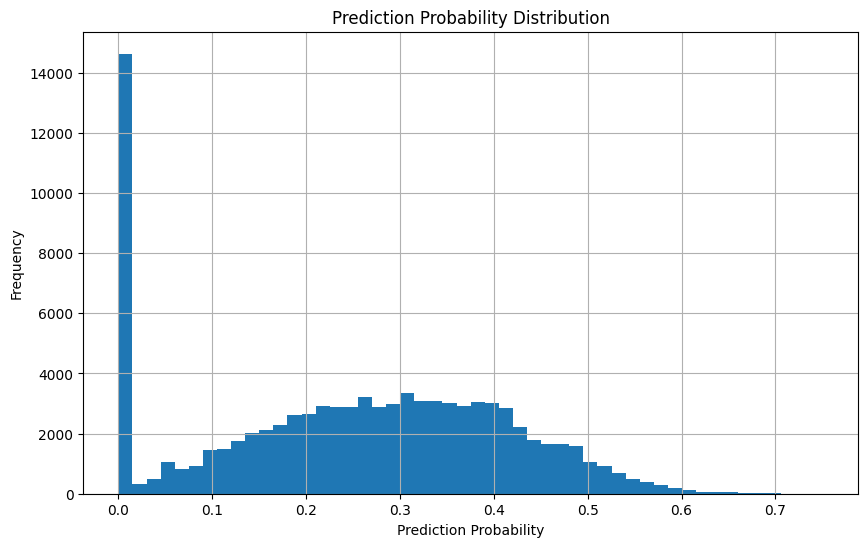

Prediction Probability Statistics:
Mean: 0.2502
Standard Deviation: 0.1589
Minimum: 0.0006
Maximum: 0.7505


In [38]:
plt.figure(figsize=(10, 6))
plt.hist(pred_proba, bins=50)
plt.title('Prediction Probability Distribution')
plt.xlabel('Prediction Probability')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

print(f'Prediction Probability Statistics:')
print(f'Mean: {pred_proba.mean():.4f}')
print(f'Standard Deviation: {pred_proba.std():.4f}')
print(f'Minimum: {pred_proba.min():.4f}')
print(f'Maximum: {pred_proba.max():.4f}')

### F. Submission

In [39]:
sample_submission = pd.read_csv('../data/sample_submission.csv')
sample_submission['probability'] = pred_proba

In [32]:
sample_submission.to_csv('../results/lgbm.1.csv', index=False)